<a href="https://colab.research.google.com/github/andersonsam/cnn_lstm_era/blob/master/main_publish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#still to fix:

#Ntrain != actual number of training observations

# Preliminary

In [1]:
#download required libraries which are not in colab

!pip install geopandas
!pip install netCDF4
!pip install guppy3

     |████████████████████████████████| 972kB 8.9MB/s 
     |████████████████████████████████| 10.9MB 28.9MB/s 
     |████████████████████████████████| 14.8MB 211kB/s 
     |████████████████████████████████| 4.3MB 8.4MB/s 
     |████████████████████████████████| 296kB 54.6MB/s 
     |████████████████████████████████| 604kB 9.5MB/s 


In [2]:
#load in functions required and dependencies to use them

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm#, colors, path
from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from scipy import interpolate
from scipy.stats import ks_2samp
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

import pickle
import os
from random import seed
from datetime import datetime, date
from netCDF4 import Dataset
from guppy import hpy
from google.colab import drive

from shapely.geometry import Point, Polygon
from descartes import PolygonPatch


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#define functions

def nse(y_obs, y_model):

  """
  NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  """

  if not isinstance(y_obs, np.ndarray): #if tensor, convert to numpy array
    y_obs = np.array(y_obs)
  if not isinstance(y_model, np.ndarray):
    y_model = np.array(y_model)

  y_model = y_model.reshape((-1,1)) #make sure model and obs have same shape
  y_obs = y_obs.reshape((-1,1))

  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2) #calculate NSE

  return nse

def plot_prov_ax(prov, ax):

    """
    plot borders of a province on a given axis
    
    prov: string; 'AB', 'BC', or 'AB_BC'
    ax: axis on which to plot the provincial borders
    """
    
    if prov == 'AB_BC':
      provs = ['AB', 'BC']
      for prov in provs:
        if prov == 'AB':
          provIndex=0
        elif prov == 'BC':
          provIndex = 11
        provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/PROVINCE.SHP'
        provshapes = gpd.read_file(provshapes_filename)
        provPoly = provshapes['geometry'][provIndex]

        if len(np.shape(provPoly)) == 0: #if only one polygon to plot

          lonBorder,latBorder = provPoly.exterior.coords.xy 
          ax.plot(lonBorder,latBorder,'k')

        else: #if multiply polygons in shape to plot

          for ind in range(len(provPoly)):

            lonBorder_segment,latBorder_segment = provPoly[ind].exterior.coords.xy 
            ax.plot(lonBorder_segment,latBorder_segment,'k')

    else:
      if prov == 'AB':
        provIndex=0
      elif prov == 'BC':
        provIndex = 11
      provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/PROVINCE.SHP'
      provshapes = gpd.read_file(provshapes_filename)
      provPoly = provshapes['geometry'][provIndex]

      if len(np.shape(provPoly)) == 0: #if only one polygon to plot

        lonBorder,latBorder = provPoly.exterior.coords.xy 
        ax.plot(lonBorder,latBorder,'k')

      else: #if multiply polygons in shape to plot

        for ind in range(len(provPoly)):

          lonBorder_segment,latBorder_segment = provPoly[ind].exterior.coords.xy 
          ax.plot(lonBorder_segment,latBorder_segment,'k')

def rmse(target,prediction):

  """
  Returns the root-mean-square error between a target and prediction
  target, prediction: arrays or tensors of equal length

  Example: 
  RMSE = rmse(target,prediction) 
  """

  if not isinstance(target, np.ndarray):
    target = np.array(target)
  if not isinstance(prediction, np.ndarray):
    prediction = np.array(prediction)

  return(np.sqrt(((target.reshape(-1,1) - prediction.reshape(-1,1))**2).sum()/len(target.reshape(-1,1))))

def get_A(heat):

  """
  Returns the area (as a fraction of the total heatmap) which is above the half-maximum value

  Example:
  A = get_A(heat = heat_mean)
  """

  halfMax = 0.5* (np.max(heat) - np.min(heat))
  n_hot_pixels = len(np.argwhere((heat - np.min(heat)) > halfMax))
  n_pixels = np.size(heat)
  A = n_hot_pixels / n_pixels

  return A

def make_heat(model, x_test, y_test, style_dict, days, iters_total, iters_one_pass, output_dir, saveFiles, stationInds, verbose):

  """
  model: 
      .h5 keras model
  x_test:
      tf tensor; test set of ERA data, input to model (shape = Ntest x 365 x height x width x channels)
  y_test:
      tf tensor; test set of streamflow data, target output of model (shape = Ntest x Nstations)
  style_dict:
      dictionary: {'style' : 'RISE' or 'gauss',
                   'params' : [h,w,p_1] or sigma}
          where [h,w,p_1] are the height/width/probability of perturbation of low-res mask (for RISE algorithm); sigma is the gaussian RMS width
  days:
      range of days in test set to perturb (e.g. days = range(0,365) will perturb the first 365 days in the test set)
  iters_total:
      number of total iterations of perturbation to do for each day in days
  iters_one_pass:
      number of iterations to do at one time (typically less than iters_total for memory limits)
  output_dir:
      directory where output will be saved, string 
  save_files:
      0 or 1 (False or True) if output heat maps are to be saved to the output_dir or not
  stationInds:
      indices of stations corresponding to the output neurons of the keras model
  verbose:
      0: print nothing
      1: print every 50th day
      2: print every day and iteration
  """

  n_channels = np.shape(x_test)[-1] #number of channels of input video
  H = np.shape(x_test)[2] #height of input video, in pixels
  W = np.shape(x_test)[3] #width of input video, in pixels

  heat_all_slices = [[] for station in range(np.shape(y_test)[0])] #list of empty lists (one empty list per output station)

  for day in days: #for each day in test set that we will perturb

    if verbose == 1 and np.mod(day,50) == 0:
      print('Day ' + str(day) + '/' + str(days[-1])) 

    for kk in range(int(iters_total/iters_one_pass)): #for each batch of iterations 

      #number of iterations of perturbations for one forward pass through model
      iters = iters_one_pass 

      #define perturbation
      if style_dict['style'] == 'RISE':
    
        h = style_dict['params'][0]
        w = style_dict['params'][1]
        p_1 = style_dict['params'][2]

        x_int = np.linspace(0,W,w) #low-res x indices
        y_int = np.linspace(0,H,h) #low-res y indices

        xnew = np.arange(W)
        ynew = np.arange(H) 

        perturb_small = np.random.choice([0,1],size = (iters,1,h,w), p = [1-p_1,p_1])
        perturb = np.half([interpolate.interp2d(x_int,y_int,perturb_small[iter][0])(xnew,ynew) for iter in range(iters)])

      elif style_dict['style'] == 'gauss':
        
        sigma = style_dict['params']

        x_int = np.arange(W)
        y_int = np.arange(H)

        x_mesh, y_mesh = np.meshgrid(x_int, y_int)
        pointx = np.random.randint(0,np.shape(Tmaxnorm[0])[1])
        pointy = np.random.randint(0,np.shape(Tmaxnorm[0])[0])
        d2 = (x_mesh - pointx)**2 + (y_mesh - pointy)**2
        perturb = np.half([np.exp( -d2 / (2*sigma**2)) for iter in range(iters)])

      perturb_2D = np.copy(perturb)
      perturb = tf.repeat(tf.expand_dims(tf.convert_to_tensor(perturb),3),nchannels, axis = 3)
      perturb = tf.repeat(tf.expand_dims(tf.convert_to_tensor(perturb),1),365, axis = 1)

      xday = x_test[day]
      xday_iters = [xday for val in range(iters)]

      factor = np.random.choice([-1,1],p = [0.5,0.5]) #whether to add or subtract perturbation from input video
      perturb = factor*perturb
      x1 = perturb
      x2 = tf.convert_to_tensor(xday_iters)
      xday_iters_mask = tf.math.add(x1,x2)#.numpy()

      x_all = tf.squeeze(tf.concat((tf.expand_dims(xday, axis = 0),xday_iters_mask), axis = 0))
      x_all_ds = tf.data.Dataset.from_tensor_slices(x_all).batch(batch_size = 64)
      y_all = model.predict(x_all_ds)

      yday = y_all[0]
      yday_mask = y_all[1:]

      for station in range(np.shape(y_all)[1]):

        yday_station = yday[:,station]
        yday_station_mask = yday_mask[:,station]

        ydiffs = np.abs(np.reshape(yday_station[0] - yday_station_mask[:iters],(-1,1)))
        delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None]
        heat_iters = [np.asarray(delta[:iters]) * np.asarray(perturb_2D)]
        heat_iters = np.reshape(heat_iters,(iters,H,W))
        heat = [np.mean(heat_iters[:iters], axis=0)] #fast
        
        heat_all_slices[station].append(heat[0]) #fast

      del heat, heat_iters, delta, ydiffs, x_all, xday_iters

    heat_mean = np.empty( (np.shape(y_all)[1] ,) + np.shape(np.mean(heat_all_slices[0],axis=0)) )
    for station in range(np.shape(y_all)[1]):
      heat_mean[station] = np.mean(heat_all_slices[station],axis=0)

  for zz, station in enumerate(stationInds):

    # heat_days_vec = np.empty((len(days),np.size(x_test[0,0,:,:,0])))
    # for day in days:
    #   heat_days_vec[day,:] = np.reshape(heat_days[zz][day],(1,-1))

    if saveFiles:

      fileName = 'heat_mean_station_' + str(station) + '.csv'

      if not os.path.exists(output_dir):
        os.mkdir(output_dir)
      np.savetxt(output_dir + '/' + fileName, heat_mean[zz], delimiter = ',')

  return heat_mean

def plot_dendrogram(model, **kwargs):

  """
  model: Agglomerative clustering model

  Creates linkage matrix and then plots the dendrogram
  Returns dendrogram

  Code from: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
  """

  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
      current_count = 0
      for child_idx in merge:
          if child_idx < n_samples:
              current_count += 1  # leaf node
          else:
              current_count += counts[child_idx - n_samples]
      counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)

  # Plot the corresponding dendrogram
  d = dendrogram(linkage_matrix, **kwargs)

  return d

In [5]:
def build_fine_model(model_bulk, N_stations):
  
  learning_rate = 0.0001

  model_fine = tf.keras.models.clone_model(model_bulk)
  model_fine.set_weights(model_bulk.get_weights())
  model_fine.pop() #remove last dense layer
  model_fine.add(Dense(N_stations, activation = 'linear')) #add new dense layer with # neurons = # stations

  model_fine.compile(
      loss=tf.keras.losses.MSE,
      optimizer=tf.keras.optimizers.Adam(lr=learning_rate)
      )
  
  return model_fine

In [6]:
def save_bulk_model(model, model_name):

  dir_all_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/final_models'
  dir_bulk_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/final_models/bulk'
  
  if not os.path.exists(dir_all_models):
    os.mkdir(dir_all_models)
  if not os.path.exists(dir_bulk_models):
    os.mkdir(dir_bulk_models)

  model.save(dir_bulk_models + '/' + model_name)



In [7]:
def train_model(model, train_dataset, val_dataset, callbacks):

  #train model
  model.fit(
      train_dataset,
      validation_data = val_dataset,
      epochs = 200,
      verbose = 0, 
      callbacks = [callbacks]
      )
  
  return model

In [8]:
def build_bulk_model():

  #build model

  learning_rate = 0.0001

  #CNN model

  model = Sequential()

  model.add(
      TimeDistributed(
          Conv2D(
              filters = 32, 
              kernel_size = (1,1), 
              activation='relu',
              data_format='channels_last', 
              padding='same'
              ), 
              input_shape=(365,)+np.shape(Tmaxnorm[0])+(nchannels,)
              )
      )
  
  model.add(
      TimeDistributed(
          Conv2D(
              filters = 16, 
              kernel_size = (3,3), 
              activation='relu',
              data_format='channels_last', 
              padding='same'
              ), 
              input_shape=(365,)+np.shape(Tmaxnorm[0])+(nchannels,)
              )
      )
  
  model.add(
    TimeDistributed(
        Conv2D(
            filters = 16, 
            kernel_size = (3,3), 
            activation='relu',
            data_format='channels_last', 
            padding='same'
            ), 
            input_shape=(365,)+np.shape(Tmaxnorm[0])+(nchannels,)
            )
    )

  model.add(
      TimeDistributed(
          MaxPooling2D(
              pool_size = 2)
          )
      )

  model.add(
      TimeDistributed(
          Conv2D(
              filters = 32, 
              kernel_size = (3,3), 
              activation='relu',
              data_format='channels_last', 
              padding='same'
              ),
              )
      )

  model.add(
      TimeDistributed(
          Conv2D(
              filters = 32, 
              kernel_size = (3,3), 
              activation='relu',
              data_format='channels_last', 
              padding='same'
              ), 
              )
      )

  model.add(
      TimeDistributed(
          GlobalMaxPooling2D(
              data_format='channels_last')
          )
      )

  model.add(
      TimeDistributed(
          Flatten()
          )
      )

  model.add(
      Dropout(
          rate = 0.1
          )
      )

  #LSTM
  model.add(
      LSTM(
          80, 
           return_sequences=False
           )
      )

  #Dense
  model.add(
      Dense(
          np.shape(F)[1], 
          activation = 'linear'
          )
      )

  #compile
  model.compile(loss=tf.keras.losses.MSE,
                  optimizer=tf.keras.optimizers.Adam(lr=learning_rate))
  
  return model

In [9]:
def make_heat(model, x_test, y_test, style_dict, days, iters_total, iters_one_pass, stationInds, verbose):

  """
  model: 
      .h5 keras model
  x_test:
      tf tensor; test set of ERA data, input to model (shape = Ntest x 365 x height x width x channels)
  y_test:
      tf tensor; test set of streamflow data, target output of model (shape = Ntest x Nstations)
  style_dict:
      dictionary: {'style' : 'RISE' or 'gauss',
                   'params' : [h,w,p_1] or sigma}
          where [h,w,p_1] are the height/width/probability of perturbation of low-res mask (for RISE algorithm); sigma is the gaussian RMS width
  days:
      range of days in test set to perturb (e.g. days = range(0,365) will perturb the first 365 days in the test set)
  iters_total:
      number of total iterations of perturbation to do for each day in days
  iters_one_pass:
      number of iterations to do at one time (typically less than iters_total for memory limits)
  output_dir:
      directory where output will be saved, string 
  save_files:
      0 or 1 (False or True) if output heat maps are to be saved to the output_dir or not
  stationInds:
      indices of stations corresponding to the output neurons of the keras model
  verbose:
      0: print nothing
      1: print every 50th day
      2: print every day and iteration
  """

  n_channels = np.shape(x_test)[-1] #number of channels of input video
  H = np.shape(x_test)[2] #height of input video, in pixels
  W = np.shape(x_test)[3] #width of input video, in pixels

  #heat_all_slices = [np.zeros(np.shape(x_test[0,0,:,:,0])) for station in range(np.shape(y_test)[0])] #list of empty lists (one empty list per output station)
  heat_mean = np.zeros((np.size(x_test[0,0,:,:,0]), len(stationInds)))

  #heat_mean = np.zeros((len(eraLat)*len(eraLon), len(stationInds))) 

  for day in days: #for each day in test set that we will perturb

    if verbose:
      if np.mod(day,50)==0:
        print(' Day ' + str(day) + '/' + str(len(days)))

    for kk in range(int(iters_total/iters_one_pass)): #for each batch of iterations 

      #number of iterations of perturbations for one forward pass through model
      iters = iters_one_pass 

      #define perturbation
      if style_dict['style'] == 'RISE':
    
        h = style_dict['params'][0]
        w = style_dict['params'][1]
        p_1 = style_dict['params'][2]

        x_int = np.linspace(0,W,w) #low-res x indices
        y_int = np.linspace(0,H,h) #low-res y indices

        xnew = np.arange(W)
        ynew = np.arange(H) 

        perturb_small = np.random.choice([0,1],size = (iters,1,h,w), p = [1-p_1,p_1])
        perturb = np.half([interpolate.interp2d(x_int,y_int,perturb_small[iter][0])(xnew,ynew) for iter in range(iters)])

      elif style_dict['style'] == 'gauss':
        
        sigma = style_dict['params']

        x_int = np.arange(W)
        y_int = np.arange(H)

        x_mesh, y_mesh = np.meshgrid(x_int, y_int)
        pointx = np.random.randint(0,np.shape(Tmaxnorm[0])[1])
        pointy = np.random.randint(0,np.shape(Tmaxnorm[0])[0])
        d2 = (x_mesh - pointx)**2 + (y_mesh - pointy)**2
        perturb = np.half([np.exp( -d2 / (2*sigma**2)) for iter in range(iters)])

      perturb_2D = np.copy(perturb)
      perturb = tf.repeat(tf.expand_dims(tf.convert_to_tensor(perturb),3),nchannels, axis = 3)
      perturb = tf.repeat(tf.expand_dims(tf.convert_to_tensor(perturb),1),365, axis = 1)

      xday = x_test[day]
      xday_iters = [xday for val in range(iters)]

      factor = np.random.choice([-1,1],p = [0.5,0.5]) #whether to add or subtract perturbation from input video
      perturb = factor*perturb
      x1 = perturb
      x2 = tf.convert_to_tensor(xday_iters)
      xday_iters_mask = tf.math.add(x1,x2)#.numpy()

      x_all = tf.squeeze(tf.concat((tf.expand_dims(xday, axis = 0),xday_iters_mask), axis = 0))
      x_all_ds = tf.data.Dataset.from_tensor_slices(x_all).batch(batch_size = 64)
      y_all = model.predict(x_all_ds)

      yday = y_all[0]
      yday_mask = y_all[1:]

      for station in range(np.shape(y_all)[1]):

        yday_station = yday[station]
        yday_station_mask = yday_mask[:,station]

        ydiffs = np.abs(np.reshape(yday_station - yday_station_mask[:iters],(-1,1)))
        delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None]
        heat_iters = [np.asarray(delta[:iters]) * np.asarray(perturb_2D)]
        heat_iters = np.reshape(heat_iters,(iters,H,W))
        heat = [np.mean(heat_iters[:iters], axis=0)] #fast

        heat_mean[:,station] += heat[0].flatten()

      del heat, heat_iters, delta, ydiffs, x_all, xday_iters

  heat_mean = heat_mean /(iters_total * len(days))

  return heat_mean


# Prep data

In [10]:
prov = 'AB_BC' #for plotting (plot_prov)
flowpickle = ['BC_flowvars_1979_2015.pickle', 'AB_flowvars_1979_2015.pickle'] #filenames of pickle files which contain AB/BC streamflow data
basinspickle = 'AB_BC_basins2_1979_2015.pickle' #filename of pickle file which contains the basin outlines

In [11]:
#load data

colabDataPath = '/content/drive/My Drive/Colab Notebooks/T_P_F_pca_lstm/'

pickle_in = open(colabDataPath + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)

flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(colabDataPath + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

flowDict = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])),
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])),
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])),
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])),
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])),
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])),
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])),
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])),
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])),
    'windowDates' : flowDicts[0]['windowDates'],
    'windowYears' : flowDicts[0]['windowYears'],
    'windowMonths' : flowDicts[0]['windowMonths'],
    'windowDays' : flowDicts[0]['windowDays'],
}

pickle_in = open(colabDataPath + 'tempDict.pickle','rb')
pickle_in = open(colabDataPath + 'tempDict_ERA5_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

pickle_in = open(colabDataPath + 'precDict.pickle','rb')
pickle_in = open(colabDataPath + 'precDict_ERA5_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

#unpack data
stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flow_NF'] #discharge with nans filled (NF)
Tmax = np.asarray(tempDict['Tmax'])
Tmin = np.asarray(tempDict['Tmin'])
P = np.asarray(precDict['P'])

In [12]:
#select subset of stations

maxLat = 56.
stationInds = np.squeeze(np.argwhere(np.expand_dims(stationLat,1)<maxLat)[:,0])

F = np.asarray(F)
F = np.transpose(np.squeeze(F[stationInds]))

stationBasins = [stationBasins[ii] for ii in stationInds]

In [13]:
#reduce spatial extent to only bound the stations of interest (reduce memory requirements)

bounding_box = 1 #1/0 yes/no if you want to reduce the spatial extent
border = 1 #number of pixels to border the outermost stations

if bounding_box:

  minLon = np.min(stationLon[stationInds])
  maxLon = np.max(stationLon[stationInds])
  minLat = np.min(stationLat[stationInds])
  maxLat = np.max(stationLat[stationInds])

  indMinLonERA = np.argmin(np.abs(eraLon - minLon))
  indMaxLonERA = np.argmin(np.abs(eraLon - maxLon))
  indMinLatERA = np.argmin(np.abs(eraLat - minLat))
  indMaxLatERA = np.argmin(np.abs(eraLat - maxLat))

  if indMinLatERA + border > len(eraLat) - 1:
    indMinLatERA = len(eraLat) - 1
  else:
    indMinLatERA = indMinLatERA + border

  if indMaxLatERA - border < 1:
    indMaxLatERA = 0
  else:
    indMaxLatERA = indMaxLatERA - border + 1

  if indMaxLonERA + border > len(eraLon) - 1:
    indMaxLonERA = len(eraLon) - 1
  else:
    indMaxLonERA = indMaxLonERA + border

  if indMinLonERA - border < 1:
    indMinLonERA = 0
  else:
    indMinLonERA = indMinLonERA - border

  Tmax = Tmax[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  Tmin = Tmin[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  P = P[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]

  d_eraLon = eraLon[1] - eraLon[0]
  d_eraLat = eraLat[0] - eraLat[1]

  extentERA = [eraLon[indMinLonERA] - d_eraLon/2,eraLon[indMaxLonERA] + d_eraLon/2,eraLat[indMinLatERA] - d_eraLat/2,eraLat[indMaxLatERA] + d_eraLat/2]
  eraLon = eraLon[indMinLonERA:indMaxLonERA+1]
  eraLat = eraLat[indMaxLatERA:indMinLatERA+1]

In [14]:
#standardize data

#indices of testing/training
trainStartYear = 1979
trainFinYear = 2000
valStartYear = 2001
valFinYear = 2010
testStartYear = 2011
testFinYear = 2015

trainInds = np.squeeze(np.argwhere((flowYears>=trainStartYear) & (flowYears<=trainFinYear)))
valInds = np.squeeze(np.argwhere((flowYears>=valStartYear) & (flowYears<=valFinYear)))
testInds = np.squeeze(np.argwhere((flowYears>=testStartYear) & (flowYears<=testFinYear)))
Ntrain = len(trainInds)
Nval = len(valInds)
Ntest = len(testInds)

#standardize weather variables (normalize wrt training period), then save as np.single for memory
Tmaxmean_train = np.mean([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxstd_train = np.std([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxnorm = (Tmax - Tmaxmean_train)/Tmaxstd_train
Tmaxnorm = np.single(Tmaxnorm)

Tminmean_train = np.mean([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminstd_train = np.std([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminnorm = (Tmin - Tminmean_train)/Tminstd_train
Tminnorm = np.single(Tminnorm)

Pmean_train = np.mean([P[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train = np.std([P[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm = (P - Pmean_train)/Pstd_train
Pnorm = np.single(Pnorm)

#normalize flow wrt to training period for each station
Fnorm = np.empty_like(F)
for station in range(np.shape(F)[1]):
    Fnorm[:,station] = (F[:,station] - np.mean(F[trainInds,station]))/np.std(F[trainInds,station])

In [15]:
#construct train and test predictor/target tensors

#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T #drop first 365 days since those are used to predict first flow day
y_val = np.squeeze([Fnorm[valInds,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T

y_train = y_train.astype(dtype = np.float16)
y_val = y_val.astype(dtype = np.float16)
y_test = y_test.astype(dtype = np.float16)

#predictor data
nchannels = 3 
x_train = np.empty((Ntrain-365, 365, ) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
x_val = np.empty((Nval, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,), dtype = np.float16)
x_test = np.empty((Ntest, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

#training
for ii in range(Ntrain-365):
  x_train[ii] = x_intermediate[ii:ii+365]

#validation
for ii in range(Nval):
  x_val[ii] = x_intermediate[ii + Ntrain - 365 : ii + Ntrain]

#testing
for ii in range(Ntest):
  x_test[ii] = x_intermediate[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]

#convert predict/target arrays to tensors
x_test = tf.convert_to_tensor(x_test)
x_val = tf.convert_to_tensor(x_val)
x_train = tf.convert_to_tensor(x_train)
y_test = tf.convert_to_tensor(y_test)
y_val = tf.convert_to_tensor(y_val)
y_train = tf.convert_to_tensor(y_train)

# Cluster seasonal flow

In [16]:
#create cluster input: half seasonal, quarter lat, quarter lon

frac_space = 0.5 #fraction of input vector to be the lat/lon

len_input = int(365/frac_space)
cluster_input = np.empty((len(stationInds), len_input))
flowseason = flowDict['all_flowseason_NF'][stationInds,:]
stationLat_norm = (stationLat[stationInds] - np.mean(stationLat[stationInds])) / np.std(stationLat[stationInds])
stationLon_norm = (stationLon[stationInds] - np.mean(stationLon[stationInds])) / np.std(stationLon[stationInds])

for station in range(len(stationInds)):
  cluster_input[station,:365] = (flowseason[station,:] - np.mean(flowseason[station,:])) / np.std(flowseason[station,:]) #first half is normalized seasonal streamflow
  lat_inds = np.arange(365,365 + int((len_input - 365)/2))
  lon_inds = np.arange(365 + int((len_input - 365)/2), len_input)
  cluster_input[station,lat_inds] = stationLat_norm[station] * np.ones_like(lat_inds)
  cluster_input[station,lon_inds] = stationLon_norm[station] * np.ones_like(lon_inds)

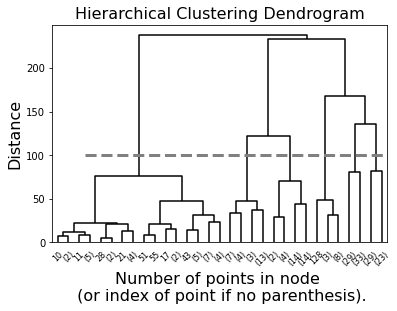

In [17]:
#visualize dendrogram to inform number of clusters

saveIt = 0 #if save figure as a PNG file
saveEPS = 0 #if save figures as an EPS file

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(cluster_input)
plt.title('Hierarchical Clustering Dendrogram', fontsize = 16)
# plot the top three levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold = 0, above_threshold_color = 'k')

cutoff = 100
linemin = 30
linemax = 310
plt.plot([linemin,linemax],[cutoff,cutoff], color = 'gray', linestyle = '--', linewidth = 3)
plt.xlabel("Number of points in node \n (or index of point if no parenthesis).", fontsize = 16)
plt.ylabel('Distance', fontsize = 16)

if saveIt: 
  plt.savefig('dendrogram_seasonal.png', dpi = 200, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('dendrogram_seasonal.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [18]:
#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal = 6
seasonal_clustering = AgglomerativeClustering(n_clusters = n_clusters_seasonal).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters_seasonal, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal):
  cluster_inds = np.argwhere(seasonal_clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

In [19]:
#determine RGB values of colormap to use: from coolors.co

rgbs = [[241, 135, 1],
      [205, 223, 160],
      [159, 222, 249],
      [233, 134, 207],
      [21, 96, 121],
      [100, 23, 35]]

rgbas = [[241, 135, 1,256],
      [205, 223, 160,256],
      [159, 222, 249,256],
      [233, 134, 207,256],
      [21, 96, 121,256],
      [100, 23, 35,256]]

rgbs_array = np.asarray(rgbs)/256
rgbas_array = np.asarray(rgbas)/256

cStations = np.empty((len(stationInds), 3))
for kk in range(len(stationInds)):
  cStations[kk,:] = rgbs[seasonal_clustering.labels_[kk]]

cStations /= 256

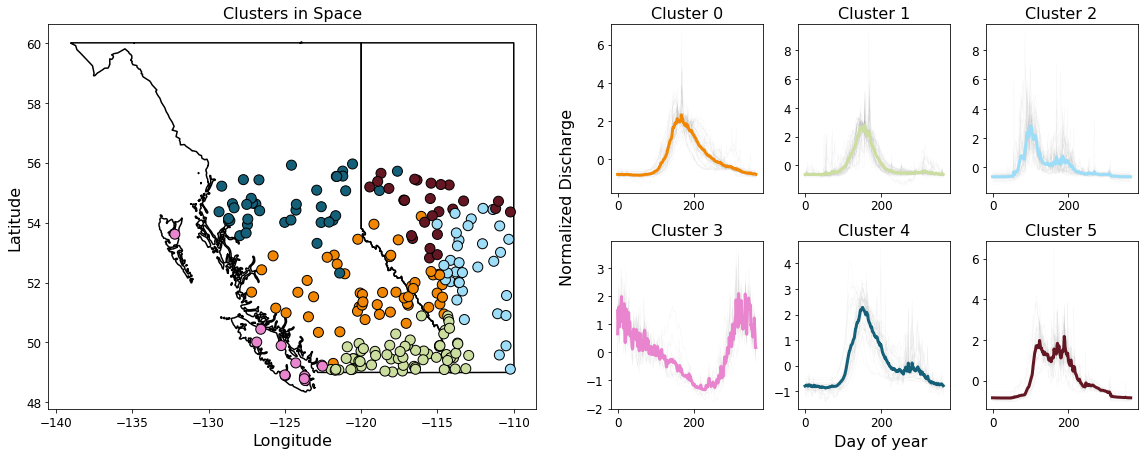

In [20]:
#visualize clustering results (spatial + temporal patterns)

saveIt = 0
saveEPS = 0

fs = 16 #fontsize

fig = plt.figure(figsize = (16,7))

ax0 = fig.add_subplot(1,2,1)
plot_prov_ax(prov=prov, ax = ax0)
ax0.scatter(stationLon[stationInds], stationLat[stationInds], c = cStations, s = 100, linewidth = 1, edgeColor = 'k', zOrder = 3)
ax0.tick_params(labelsize = 12)
ax0.set_xlabel('Longitude', fontsize = fs)
ax0.set_ylabel('Latitude', fontsize = fs)
ax0.set_title('Clusters in Space', fontsize = fs)

subplot_inds = [3,4,5,9,10,11] #the right-side indices in a 2row x 6col grid, for plotting the temporal pattern
cluster = 0
for cluster, subplot_ind in enumerate(subplot_inds):
  ax = fig.add_subplot(2,6,subplot_ind+1)
  cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  ax.plot(cluster_input[cluster_inds,:365].T, linewidth = 0.25, alpha = 0.1, color = 'gray')
  ax.plot(cluster_patterns[cluster,:365], color = rgbs_array[cluster], linewidth = 3)
  ax.tick_params(labelsize = 12)
  ax.set_title('Cluster ' + str(cluster), fontsize = fs)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

ax0.text(-107,52, 'Normalized Discharge', fontsize = fs, rotation = 90) #manually add axis labels to control tight-layout aesthetic 
ax0.text(-89,46.55, 'Day of year', fontsize = fs)

if saveIt:
  plt.savefig('cluster_patterns.png', bbox_inches = 'tight', dpi = 200)

if saveEPS:
  plt.savefig('cluster_patterns.eps', format = 'eps', bbox_inches='tight')

plt.show()

# Train bulk and fine-tuned models

In [24]:
dir_all_models

'/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/final_models'

In [25]:
seeds = [00, 11, 22, 33, 44, 55, 66, 77, 88, 99] #random seeds to use for reproducability
#seeds = [00]
seeds = [11, 22, 33, 44, 55, 66, 77, 88, 99]
seeds = [55, 66, 77, 88, 99]
seeds = [88,99]
seeds = [99]
seeds = [88]

sigma = 1.5
style_dict = {'style' : 'gauss',
              'params' : sigma}

days_heat = range(365)
iters_total = 200
iters_one_pass = 50
output_dir_heat = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/heat'

# for ii, s in enumerate(seeds):
ii = 8
for s in seeds:

  print('Training bulk model ' + str(ii+1) + ' / ' + str(len(seeds)))

  #set random seeds
  seed(s)
  np.random.seed(s)
  tf.random.set_seed(s)

  #define early stopping callback to use in all models
  callbacks = EarlyStopping(monitor='val_loss', 
                          mode='min', 
                          verbose=1, 
                          patience = 5,
                          restore_best_weights = True)

  #create train/val/test datasets for bulk model
  batch_size = 64
  train_dataset_bulk = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(Ntrain).batch(batch_size)
  val_dataset_bulk = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(Nval).batch(batch_size)
  test_dataset_bulk = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(Ntest).batch(batch_size)

  #generate/train bulk model
  # model_bulk = build_bulk_model()
  # model_bulk = train_model(model = model_bulk, train_dataset = train_dataset_bulk, val_dataset = val_dataset_bulk, callbacks = callbacks)
  model_bulk = tf.keras.models.load_model(dir_all_models + '/model_bulk_8.h5')

  #predict train/val/test streamflow
  y_train_predict_bulk = model_bulk.predict(x_train, batch_size = batch_size, verbose = 0)
  y_val_predict_bulk = model_bulk.predict(x_val, batch_size = batch_size, verbose = 0)
  y_test_predict_bulk = model_bulk.predict(x_test, batch_size = batch_size, verbose = 0)

  #save bulk model outputs
  dir_all_outputs = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/final_model_output'
  file_train = 'y_train_bulk_predict_' + str(ii) + '.csv'
  file_val = 'y_val_bulk_predict_' + str(ii) + '.csv'
  file_test = 'y_test_bulk_predict_' + str(ii) + '.csv'
  if not os.path.exists(dir_all_outputs):
    os.mkdir(dir_all_outputs)
  np.savetxt(dir_all_outputs + '/' + file_train, y_train_predict_bulk, delimiter = ',')
  np.savetxt(dir_all_outputs + '/' + file_val, y_val_predict_bulk, delimiter = ',')
  np.savetxt(dir_all_outputs + '/' + file_test, y_test_predict_bulk, delimiter = ',')

  #save bulk model
  dir_all_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/final_models'
  model_name = 'model_bulk_' + str(ii) + '.h5'
  if not os.path.exists(dir_all_models): #make directory for all models if it doesn't exist
    os.mkdir(dir_all_models)
  model_bulk.save(dir_all_models + '/' + model_name)

  #generate bulk heat maps
  print(' Making sensitivity heat maps')
  output_dir_heat = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/heat_maps'
  if not os.path.exists(output_dir_heat):
    os.mkdir(output_dir_heat)
  output_dir_bulk_heat = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/heat_maps/bulk'
  heat_mean_bulk = make_heat(
      model = model_bulk, 
      x_test = x_test, 
      y_test = y_test, 
      style_dict = style_dict, 
      days = days_heat, 
      iters_total = iters_total, 
      iters_one_pass = iters_one_pass, 
      stationInds = range(len(stationInds)),
      verbose = 0
      )
  fileName = 'heat_mean_bulk_' + str(ii) + '.csv'
  np.savetxt(output_dir_bulk_heat + '/' + fileName, heat_mean_bulk, delimiter = ',')

  #prep fine-tune target output
  y_train_predict_fine_all = np.empty_like(y_train)
  y_val_predict_fine_all = np.empty_like(y_val)
  y_test_predict_fine_all = np.empty_like(y_test)

  #for each streamflow cluster, make/train/save fine-tuned model  
  heat_mean_fine = np.zeros_like(heat_mean_bulk)
  for cluster in range(n_clusters_seasonal):

    print('Training fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal))

    stations_fine = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster)) #stations in this cluster
    N_stations = len(stations_fine) #number of stations in this cluster
    
    #create target datasets (note: x is the same)
    y_train_fine_current = tf.convert_to_tensor(y_train.numpy()[:,stations_fine])
    y_val_fine_current = tf.convert_to_tensor(y_val.numpy()[:,stations_fine])
    y_test_fine_current = tf.convert_to_tensor(y_test.numpy()[:,stations_fine])

    train_dataset_fine = tf.data.Dataset.from_tensor_slices((x_train,y_train_fine_current)).shuffle(Ntrain).batch(batch_size = batch_size)
    val_dataset_fine = tf.data.Dataset.from_tensor_slices((x_val,y_val_fine_current)).shuffle(Nval).batch(batch_size = batch_size)

    #build and train fine-tuned model
    if cluster > 2:
      model_fine = build_fine_model(model_bulk = model_bulk, N_stations = N_stations)
      model_fine = train_model(model = model_fine, train_dataset = train_dataset_fine, val_dataset = val_dataset_fine, callbacks = callbacks)
    else:
      model_fine = tf.keras.models.load_model(dir_all_models + '/model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5')

    #predict train/val/test streamflow
    y_train_predict_fine = model_fine.predict(x_train, batch_size = batch_size, verbose = 0)
    y_val_predict_fine = model_fine.predict(x_val, batch_size = batch_size, verbose = 0)
    y_test_predict_fine = model_fine.predict(x_test, batch_size = batch_size, verbose = 0)

    #reorganize predictions into array that matches the bulk train/val/test structure
    for kk, station_fine in enumerate(stations_fine):
      y_train_predict_fine_all[:,station_fine] = y_train_predict_fine[:,kk]
      y_val_predict_fine_all[:,station_fine] = y_val_predict_fine[:,kk]
      y_test_predict_fine_all[:,station_fine] = y_test_predict_fine[:,kk]

    #save model 
    model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
    model_fine.save(dir_all_models + '/' + model_name)

    #generate fine-tuned heat maps
    print(' Making sensitivity heat maps')
    output_dir_fine_heat = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/heat_maps/fine'
    heat_mean_cluster = make_heat(
        model = model_fine, 
        x_test = x_test, 
        y_test = y_test, 
        style_dict = style_dict, 
        days = days_heat, 
        iters_total = iters_total, 
        iters_one_pass = iters_one_pass, 
        stationInds = stations_fine,
        verbose = 0
        )
    for zz,station in enumerate(stations_fine):
      heat_mean_fine[:,station] = heat_mean_cluster[:,zz]

    #save the in-progress heatmaps in case of crash
    fileName = 'heat_mean_fine_' + str(ii) + '_cluster_' + str(cluster) + '_inprogess.csv'
    np.savetxt(output_dir_fine_heat + '/' + fileName, heat_mean_bulk, delimiter = ',')

  fileName = 'heat_mean_fine_' + str(ii) + '.csv'
  np.savetxt(output_dir_fine_heat + '/' + fileName, heat_mean_bulk, delimiter = ',')

  dir_all_outputs = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/final_model_output'
  file_train = 'y_train_fine_predict_' + str(ii) + '.csv'
  file_val = 'y_val_fine_predict_' + str(ii) + '.csv'
  file_test = 'y_test_fine_predict_' + str(ii) + '.csv'
  if not os.path.exists(dir_all_outputs):
    os.mkdir(dir_all_outputs)
  np.savetxt(dir_all_outputs + '/' + file_train, y_train_predict_fine_all, delimiter = ',')
  np.savetxt(dir_all_outputs + '/' + file_val, y_val_predict_fine_all, delimiter = ',')
  np.savetxt(dir_all_outputs + '/' + file_test, y_test_predict_fine_all, delimiter = ',')

  ii+=1

Training bulk model 9 / 1
 Making sensitivity heat maps
Training fine model, cluster 1 / 6
 Making sensitivity heat maps
Training fine model, cluster 2 / 6
 Making sensitivity heat maps
Training fine model, cluster 3 / 6
 Making sensitivity heat maps
Training fine model, cluster 4 / 6
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
 Making sensitivity heat maps
Training fine model, cluster 5 / 6
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
 Making sensitivity heat maps
Training fine model, cluster 6 / 6
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
 Making sensitivity heat maps


In [72]:
fileName = 'heat_mean_fine_' + str(ii) + '.csv'
np.savetxt(output_dir_fine_heat + '/' + fileName, heat_mean_fine, delimiter = ',')

In [70]:
#load heat maps
filename_fine = 'heat_mean_fine_0_cluster_5.csv'
heat_mean_fine = np.asarray(pd.read_csv(output_dir_fine_heat + '/' + filename_fine, header = None))


In [71]:
heat_mean_fine

array([[1.40499799e-05, 1.31821627e-05, 9.77895059e-06, ...,
        1.09670864e-05, 1.05368355e-05, 1.12763279e-05],
       [2.30996866e-05, 2.18489956e-05, 1.60638759e-05, ...,
        1.69862112e-05, 1.69414350e-05, 1.68382802e-05],
       [3.20177430e-05, 3.10327801e-05, 2.28477172e-05, ...,
        2.29639821e-05, 2.31266406e-05, 2.15372501e-05],
       ...,
       [2.03845365e-05, 1.84330140e-05, 2.08422311e-05, ...,
        1.80371892e-05, 2.27709037e-05, 2.04538437e-05],
       [1.50422145e-05, 1.46906003e-05, 1.67521128e-05, ...,
        1.34359501e-05, 1.70116482e-05, 1.58867213e-05],
       [9.15678227e-06, 9.96740803e-06, 1.07576544e-05, ...,
        8.62844974e-06, 1.09107766e-05, 1.05004454e-05]])

# Ensemble analysis

In [44]:
#compare results from different model runs

runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
runs = [0,1,4]
#runs = [0,1,2,3,4]

NSE_fine_runs = np.empty((len(runs), len(stationInds)))
NSE_bulk_runs = np.empty((len(runs), len(stationInds)))
dNSE_runs = np.empty((len(runs), len(stationInds)))

A_fine_runs = np.empty((len(runs), len(stationInds)))
A_bulk_runs = np.empty((len(runs), len(stationInds)))
dA_runs = np.empty((len(runs), len(stationInds)))

heat_mean_fine_runs = np.empty((len(runs), np.size(Tmax[0]), len(stationInds)))
heat_mean_bulk_runs = np.empty((len(runs), np.size(Tmax[0]), len(stationInds)))

dir_all_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/final_models'
dir_all_outputs = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/final_model_output'
output_dir_bulk_heat = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/heat_maps/bulk'
output_dir_fine_heat = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/heat_maps/fine'

# for ii, run in enumerate(runs):
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  #load modelled streamflow
  filename_train_bulk = 'y_train_bulk_predict_' + str(run) + '.csv'
  filename_val_bulk = 'y_val_bulk_predict_' + str(run) + '.csv'
  filename_test_bulk = 'y_test_bulk_predict_' + str(run) + '.csv'
  filename_train_fine = 'y_train_fine_predict_' + str(run) + '.csv'
  filename_val_fine = 'y_val_fine_predict_' + str(run) + '.csv'
  filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'
  y_train_predict_bulk = np.asarray(pd.read_csv(dir_all_outputs + '/' + filename_train_bulk, header = None))
  y_val_predict_bulk = np.asarray(pd.read_csv(dir_all_outputs + '/' + filename_val_bulk, header = None))
  y_test_predict_bulk = np.asarray(pd.read_csv(dir_all_outputs + '/' + filename_test_bulk, header = None))
  y_train_predict_fine = np.asarray(pd.read_csv(dir_all_outputs + '/' + filename_train_fine, header = None))
  y_val_predict_fine = np.asarray(pd.read_csv(dir_all_outputs + '/' + filename_val_fine, header = None))
  y_test_predict_fine = np.asarray(pd.read_csv(dir_all_outputs + '/' + filename_test_fine, header = None))

  #load heat maps
  filename_bulk = 'heat_mean_bulk_' + str(run) + '.csv'
  filename_fine = 'heat_mean_fine_' + str(run) + '.csv'
  heat_mean_bulk = np.asarray(pd.read_csv(output_dir_bulk_heat + '/' + filename_bulk, header = None))
  heat_mean_fine = np.asarray(pd.read_csv(output_dir_fine_heat + '/' + filename_fine, header = None))
  heat_mean_bulk_runs[ii,:,:] = heat_mean_bulk
  heat_mean_fine_runs[ii,:,:] = heat_mean_fine

  NSE_fine = np.empty((len(stationInds),))
  NSE_bulk = np.empty((len(stationInds),))
  NSE_train_fine = np.empty((len(stationInds),))
  NSE_train_bulk = np.empty((len(stationInds),))
  NSE_val_fine = np.empty((len(stationInds),))
  NSE_val_bulk = np.empty((len(stationInds),))
  NSE_test_fine = np.empty((len(stationInds),))
  NSE_test_bulk = np.empty((len(stationInds),))
  A_fine = np.zeros((len(stationInds),))
  A_bulk= np.zeros((len(stationInds),))

  for station in range(len(stationInds)):

#####calculate NSE
    y_obs = y_test[:,station]
    y_model_fine = y_test_predict_fine[:,station]
    y_model_bulk = y_test_predict_bulk[:,station]
    NSE_fine[station] = nse(y_obs = y_obs, y_model = y_model_fine)
    NSE_bulk[station] = nse(y_obs = y_obs, y_model = y_model_bulk)
    NSE_train_fine[station] = nse(
        y_obs   = y_train[:,station],
        y_model = y_train_predict_fine[:,station]
        )
    NSE_val_fine[station] = nse(
        y_obs   = y_val[:,station],
        y_model = y_val_predict_fine[:,station]
        )
    NSE_test_fine[station] = nse(
        y_obs   = y_test[:,station],
        y_model = y_test_predict_fine[:,station]
        )
    NSE_train_bulk[station] = nse(
        y_obs   = y_train[:,station],
        y_model = y_train_predict_bulk[:,station]
        )
    NSE_val_bulk[station] = nse(
        y_obs   = y_val[:,station],
        y_model = y_val_predict_bulk[:,station]
        )
    NSE_test_bulk[station] = nse(
        y_obs   = y_test[:,station],
        y_model = y_test_predict_bulk[:,station]
        )

#####calculate A
    A_bulk[station] = get_A(heat = heat_mean_bulk[:,station])
    A_fine[station] = get_A(heat = heat_mean_fine[:,station])

  dNSE = NSE_fine - NSE_bulk
  dA = A_fine - A_bulk

  NSE_fine_runs[ii,:] = np.asarray(NSE_fine)
  NSE_bulk_runs[ii,:] = np.asarray(NSE_bulk)
  dNSE_runs[ii,:] = dNSE

  A_fine_runs[ii,:] = A_fine
  A_bulk_runs[ii,:] = A_bulk
  dA_runs[ii,:] = dA

Run 0
Run 1
Run 2


In [45]:
print('NSE train bulk = ' + str(np.median(NSE_train_bulk))[:4])
print('NSE train fine = ' + str(np.median(NSE_train_fine))[:4])
print()
print('NSE val bulk = ' + str(np.median(NSE_val_bulk))[:4])
print('NSE val fine = ' + str(np.median(NSE_val_fine))[:4])
print()
print('NSE test bulk = ' + str(np.median(NSE_test_bulk))[:4])
print('NSE test fine = ' + str(np.median(NSE_test_fine))[:4])
print()
print(np.median(NSE_fine_runs))

NSE train bulk = 0.73
NSE train fine = 0.76

NSE val bulk = 0.62
NSE val fine = 0.66

NSE test bulk = 0.64
NSE test fine = 0.66

0.657685260216935


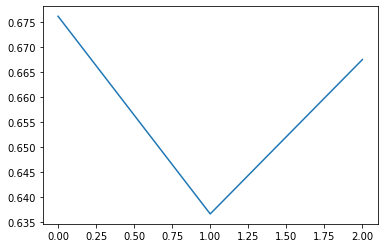

In [46]:
plt.plot(np.median(NSE_fine_runs, axis = 1))

In [47]:
#normalize each heat map

heat_mean_fine_runs_norm = np.empty_like(heat_mean_fine_runs)
heat_std_fine_runs_norm = np.empty_like(heat_mean_fine_runs)
heat_mean_bulk_runs_norm = np.empty_like(heat_mean_bulk_runs)
heat_std_bulk_runs_norm = np.empty_like(heat_mean_bulk_runs)

for station in range(len(stationInds)):
  for run in range(len(runs)):

    hh = heat_mean_fine_runs[run,:,station]
    heat_mean_fine_runs_norm[run,:,station] = (hh - np.mean(hh)) / np.std(hh)

    hh = heat_mean_bulk_runs[run,:,station]
    heat_mean_bulk_runs_norm[run,:,station] = (hh - np.mean(hh)) / np.std(hh)

heat_fine_ensemble_mean = np.mean(heat_mean_fine_runs_norm, axis = 0)
heat_bulk_ensemble_mean = np.mean(heat_mean_bulk_runs_norm, axis = 0)

# #####
# heat_fine_ensemble_mean = heat_mean_fine_runs[4,:,:]
# heat_bulk_ensemble_mean = heat_mean_bulk_runs[4,:,:]
# #####

cluster_heat_fine_mean = []

cluster_heat_bulk_mean = []
cluster_heat_bulk_std = []

for cluster in range(n_clusters_seasonal):

  inds = np.argwhere(seasonal_clustering.labels_ == cluster).reshape(-1,1)

  cluster_heat_mean_fine_current = np.squeeze(np.mean(heat_fine_ensemble_mean[:,inds], axis = 1))

  cluster_heat_mean_bulk_current = np.squeeze(np.mean(heat_bulk_ensemble_mean[:,inds], axis = 1))
  
  cluster_heat_fine_mean.append(cluster_heat_mean_fine_current)

  cluster_heat_bulk_mean.append(cluster_heat_mean_bulk_current)

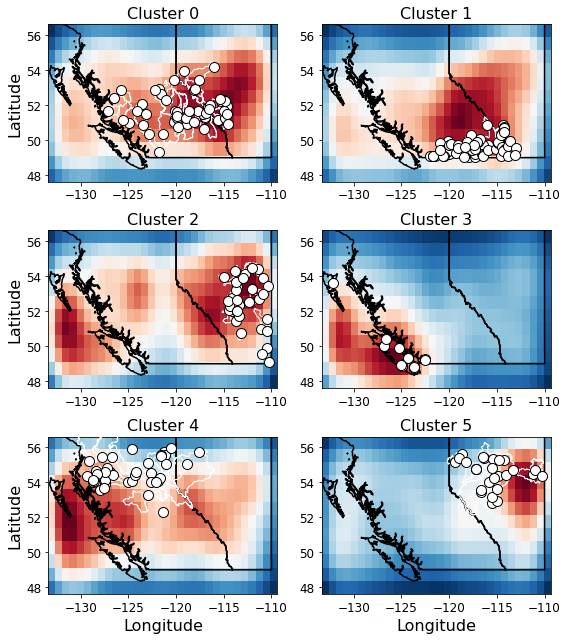

In [48]:
saveIt = 0
saveEPS = 0

fs = 16

nrows = 3
ncols = 2

fix, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols,3*nrows))

for cluster, ax in enumerate(axes.flatten()):

  inds = np.argwhere(seasonal_clustering.labels_ == cluster).reshape(-1,1)

  ax.imshow(cluster_heat_fine_mean[cluster].reshape(np.shape(Tmax[0])), aspect = 'auto', cmap = 'RdBu_r', extent = extentERA)

  for ind in inds:
    basin = stationBasins[ind[0]]
    if basin is not None:
        for poly in basin:
            for p in poly:
                x,y = p.exterior.xy
                ax.plot(x,y,'w', linewidth = 1, zOrder = 3)

  ax.scatter(stationLon[stationInds[inds]], stationLat[stationInds[inds]], s = 100, facecolor = 'w', edgecolor = 'k', zOrder = 4)
  plot_prov_ax(prov = prov, ax = ax)
  ax.tick_params(labelsize = fs-4)

  if cluster == 4 or cluster == 5:
    ax.set_xlabel('Longitude', fontsize = fs)
  if cluster == 0 or cluster == 2 or cluster == 4:
    ax.set_ylabel('Latitude', fontsize = fs)
  ax.set_title('Cluster ' + str(cluster), fontsize = fs)
  ax.set_xlim((extentERA[0], extentERA[1]))
  ax.set_ylim((extentERA[2], extentERA[3]))

plt.tight_layout()

if saveIt:
  plt.savefig('ensemble_mean_fine_sensitivity.png', dpi = 200, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('ensemble_mean_fine_sensitivity.eps', format = 'eps', bbox_inches='tight')

In [31]:
#basin difference by individual station heat maps

radius = 1.

x = eraLon
y = eraLat

xx,yy = np.meshgrid(x,y)
xxv = xx.reshape(-1)
yyv = yy.reshape(-1)

points = list(zip(xx.flatten(),yy.flatten()))

heat_in_station = [None] * len(stationInds)
heat_out_station = [None] * len(stationInds)
inside_station = [None] * len(stationInds)
unique_in_station = [None] * len(stationInds)

for station in range(len(stationInds)):

  heat_in_this_station = []
  heat_out_this_station = []
  inside_this_station = []

  heat_station = heat_fine_ensemble_mean[:,station]
  basin = stationBasins[station]
    
  if basin is not None:
    xb,yb = basin[0][0].exterior.xy
    basinPatch = PolygonPatch(basin[0])
    basinPath = matplotlib.path.Path(np.vstack((xb, yb)).T, closed = True)

    inside = basinPath.contains_points(points, radius = 0) #increasing radius sometimes produces errors -- manually define

    for ii, point in enumerate(points):
      d = np.sqrt((point[0] - xb)**2 + (point[1] - yb)**2)
      if np.min(d) <= radius:
        inside[ii] = True

    inside_this_station.append(np.argwhere(inside==True))

  elif basin is None: #if basin shapefile is missing, use stream gauge location

    xb = stationLon[stationInds][station]
    yb = stationLat[stationInds][station]
    inside = np.zeros(np.size(Tmax[0]))

    for ii, point in enumerate(points):
      d = np.sqrt((point[0] - xb)**2 + (point[1] - yb)**2)
      if np.min(d) <= radius:
        inside[ii] = True

    inside_this_station.append(np.argwhere(inside==True))

  inside_station[station] = inside_this_station
  unique_inds = []
  for kk in inside_station[station]:
    for jj in kk:
      unique_inds.append(jj[0])
  unique_in = list(set(unique_inds))
  
  unique_out = []
  for el in range(len(points)):
    if el not in unique_in:
      unique_out.append(el)
  unique_out = list(set(unique_out))

  heat_in_station[station] = heat_station[unique_in]
  heat_out_station[station] = heat_station[unique_out]

  unique_in_station[station] = unique_in

In [32]:
unique_in_this_cluster = []
unique_in_clusters = [None] * n_clusters_seasonal

for cluster in range(n_clusters_seasonal):
  unique_in_this_cluster = []
  stations_this_cluster = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  for station in stations_this_cluster:
    for ind in unique_in_station[station]:
      unique_in_this_cluster.append(ind)
  unique_in_clusters[cluster] = list(set(unique_in_this_cluster))

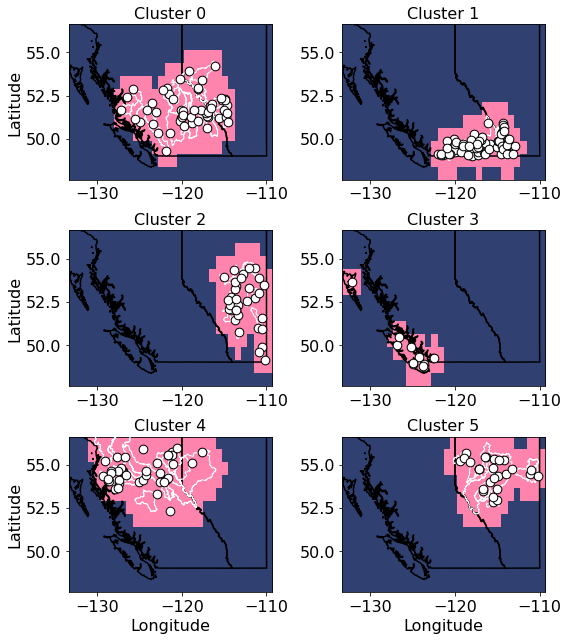

In [33]:
### figure: in/out regions around cluster basins

saveIt = 0
saveEPS = 0

rgba_binary = np.array([[49, 66, 114, 256],
              [255, 133, 175, 256]]) / 256

cmap = matplotlib.colors.ListedColormap(rgba_binary)
bounds = [0,0.5,1]
norm_binary = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

nrows = int(np.ceil(n_clusters_seasonal/2))
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))

for cluster, ax in enumerate(np.squeeze(np.reshape(axes,(-1,1)))):

  inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))

  binary_in = np.zeros(np.size(Tmax[0]))
  binary_in[unique_in_clusters[cluster]] = 1

  ax.imshow(binary_in.reshape(np.shape(Tmax[0])), aspect = 'auto', extent = extentERA, cmap = cmap, norm = norm_binary)    

  for ind in inds:
    basin = stationBasins[ind]
    if basin is not None:
        for poly in basin:
            for p in poly:
                x,y = p.exterior.xy
                ax.plot(x,y,'w', linewidth = 1, zOrder = 3)

  ax.scatter(stationLon[stationInds[inds]], stationLat[stationInds[inds]], s = 75, facecolor = 'w', edgecolor = 'k', zOrder = 4)
  plot_prov_ax(prov = prov, ax = ax)
  ax.tick_params(labelsize = fs)
  if cluster == 4 or cluster == 5:
    ax.set_xlabel('Longitude', fontsize = fs)
  if cluster == 0 or cluster == 2 or cluster == 4:
    ax.set_ylabel('Latitude', fontsize = fs)
  ax.set_title('Cluster ' + str(cluster), fontsize = fs)
  ax.set_xlim((extentERA[0], extentERA[1]))
  ax.set_ylim((extentERA[2], extentERA[3]))

fig.tight_layout()

if saveIt:
  plt.savefig('cluster_shed_in_out.png', dpi = 200, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('cluster_shed_in_out.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [34]:
heat_in_clusters = [None] * n_clusters_seasonal
heat_out_clusters = [None] * n_clusters_seasonal

for cluster in range(n_clusters_seasonal):

  heat_in_this_cluster = []
  heat_out_this_cluster = []
  stations_this_cluster = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))

  for station in stations_this_cluster:

    for temp in heat_in_station[station]:

      heat_in_this_cluster.append(temp)

    for temp in heat_out_station[station]:

      heat_out_this_cluster.append(temp)

  heat_in_clusters[cluster] = heat_in_this_cluster
  heat_out_clusters[cluster] = heat_out_this_cluster

In [35]:
ks = np.empty(n_clusters_seasonal)
p = np.empty(n_clusters_seasonal)

for cluster in range(n_clusters_seasonal):
  ks[cluster],p[cluster] = ks_2samp(heat_in_clusters[cluster], heat_out_clusters[cluster])

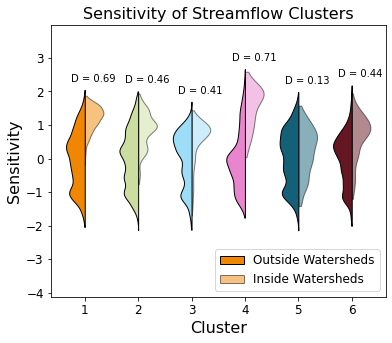

In [36]:
#help from: https://stackoverflow.com/questions/29776114/half-violin-plot

saveIt = 0
saveEPS = 0

fs = 16

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

parts_in = ax.violinplot(dataset = heat_in_clusters, showextrema = False, widths = 0.7)
parts_out = ax.violinplot(dataset = heat_out_clusters, showextrema = False, widths = 0.7)

for cluster in range(n_clusters_seasonal):

  part_in = parts_in['bodies'][cluster]
  part_out = parts_out['bodies'][cluster]

  part_out.set_facecolor(rgbas_array[cluster])
  part_out.set_edgecolor('k')
  part_out.set_alpha(1)

  part_in.set_facecolor(rgbas_array[cluster])
  part_in.set_edgecolor('k')
  part_in.set_alpha(0.5)

  m = np.mean(part_out.get_paths()[0].vertices[:, 0])
  part_out.get_paths()[0].vertices[:, 0] = np.clip(part_out.get_paths()[0].vertices[:, 0], -np.inf, m)

  m = np.mean(part_in.get_paths()[0].vertices[:, 0])
  part_in.get_paths()[0].vertices[:, 0] = np.clip(part_in.get_paths()[0].vertices[:, 0], m, np.inf)

  textx = cluster + 1 - 0.25
  texty = np.max([part_in.get_paths()[0].vertices[:, 1], part_out.get_paths()[0].vertices[:, 1]]) + 0.25
  ax.text(x = textx, y = texty, s = 'D = ' + str(ks[cluster])[:4])

ax.set_xlabel('Cluster', fontsize = fs)
ax.set_ylabel('Sensitivity', fontsize = fs)
ax.set_title('Sensitivity of Streamflow Clusters', fontsize = fs)
ax.tick_params(labelsize = fs-4)

ymin = np.min(np.min(np.asarray(heat_out_clusters))) - 2
ymax = np.max(np.max(np.asarray(heat_out_clusters))) + 2

ax.set_ylim((ymin,ymax))
ax.legend([parts_out['bodies'][0], parts_in['bodies'][0]], ['Outside Watersheds', 'Inside Watersheds'], fontsize = fs-4, loc = 'lower right')

if saveIt:
  plt.savefig('heat_in_out_dist_ensemble.png', bbox_inches = 'tight', dpi = 200)
if saveEPS:
  plt.savefig('heat_in_out_dist_ensemble.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [37]:
def get_ks(heat, radius, basins, eraLon, eraLat, stationLon, stationLat, stationInds, n_clusters, labels):

  x = eraLon
  y = eraLat

  xx,yy = np.meshgrid(x,y)
  xxv = xx.reshape(-1)
  yyv = yy.reshape(-1)

  points = list(zip(xx.flatten(),yy.flatten()))

  heat_in_station = [None] * len(stationInds)
  heat_out_station = [None] * len(stationInds)
  inside_station = [None] * len(stationInds)
  unique_in_station = [None] * len(stationInds)

  for station in range(len(stationInds)):

    heat_in_this_station = []
    heat_out_this_station = []
    inside_this_station = []

    heat_station = heat[:,station]#heat_fine_ensemble_mean[station,:]
    basin = stationBasins[station]
      
    if basin is not None:
      xb,yb = basin[0][0].exterior.xy
      basinPatch = PolygonPatch(basin[0])
      basinPath = matplotlib.path.Path(np.vstack((xb, yb)).T, closed = True)

      inside = basinPath.contains_points(points, radius = 0) #increasing radius sometimes produces errors -- manually define

      for ii, point in enumerate(points):
        d = np.sqrt((point[0] - xb)**2 + (point[1] - yb)**2)
        if np.min(d) <= radius:
          inside[ii] = True

      inside_this_station.append(np.argwhere(inside==True))

    elif basin is None: #if basin shapefile is missing, use stream gauge location

      xb = stationLon[stationInds][station]
      yb = stationLat[stationInds][station]
      inside = np.zeros(np.size(Tmax[0]))

      for ii, point in enumerate(points):
        d = np.sqrt((point[0] - xb)**2 + (point[1] - yb)**2)
        if np.min(d) <= radius:
          inside[ii] = True

      inside_this_station.append(np.argwhere(inside==True))

    inside_station[station] = inside_this_station
    unique_inds = []
    for kk in inside_station[station]:
      for jj in kk:
        unique_inds.append(jj[0])
    unique_in = list(set(unique_inds))
    
    unique_out = []
    for el in range(len(points)):
      if el not in unique_in:
        unique_out.append(el)
    unique_out = list(set(unique_out))

    heat_in_station[station] = heat_station[unique_in]
    heat_out_station[station] = heat_station[unique_out]

    unique_in_station[station] = unique_in

  unique_in_this_cluster = []
  unique_in_clusters = [None] * n_clusters_seasonal

  for cluster in range(n_clusters_seasonal):
    unique_in_this_cluster = []
    stations_this_cluster = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
    for station in stations_this_cluster:
      for ind in unique_in_station[station]:
        unique_in_this_cluster.append(ind)
    unique_in_clusters[cluster] = list(set(unique_in_this_cluster))

  heat_in_clusters = [None] * n_clusters_seasonal
  heat_out_clusters = [None] * n_clusters_seasonal

  for cluster in range(n_clusters_seasonal):

    heat_in_this_cluster = []
    heat_out_this_cluster = []
    stations_this_cluster = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))

    for station in stations_this_cluster:

      for temp in heat_in_station[station]:

        heat_in_this_cluster.append(temp)

      for temp in heat_out_station[station]:

        heat_out_this_cluster.append(temp)

    heat_in_clusters[cluster] = heat_in_this_cluster
    heat_out_clusters[cluster] = heat_out_this_cluster

  ks = np.empty(n_clusters_seasonal)
  p = np.empty(n_clusters_seasonal)

  for cluster in range(n_clusters_seasonal):
    ks[cluster],p[cluster] = ks_2samp(heat_in_clusters[cluster], heat_out_clusters[cluster])

  return ks, p

In [38]:
ks_bulk = np.zeros((len(runs), n_clusters_seasonal))
ks_fine = np.zeros((len(runs), n_clusters_seasonal))
p_bulk = np.zeros((len(runs), n_clusters_seasonal))
p_fine = np.zeros((len(runs), n_clusters_seasonal))

for run_ind in range(len(runs)):

  data = heat_mean_bulk_runs[run_ind,:,:]
  data_mean = data.mean(axis=0)
  data_std = data.std(axis=0)
  data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T

  #calculate ks for bulk
  ks_bulk[run_ind,:], p_bulk[run_ind,:] = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_)

  data = heat_mean_fine_runs[run_ind,:,:]
  data_mean = data.mean(axis=0)
  data_std = data.std(axis=0)
  data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T

  #calculate ks for bulk
  ks_fine[run_ind,:], p_bulk[run_ind,:] = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_)

#data = np.mean(heat_mean_fine_runs, axis = 0)
data = heat_fine_ensemble_mean
data_mean = data.mean(axis=0)
data_std = data.std(axis=0)
data_norm = np.asarray([(data[:,kk] - data_mean[kk]) / data_std[kk] for kk in range(len(stationInds))]).T
ks_ensemble, p_ensemble = get_ks(
      heat = data_norm, 
      radius = 1.,
      basins = stationBasins, 
      eraLon = eraLon, 
      eraLat = eraLat, 
      stationLon = stationLon, 
      stationLat = stationLat, 
      stationInds = stationInds, 
      n_clusters = n_clusters_seasonal, 
      labels = seasonal_clustering.labels_)

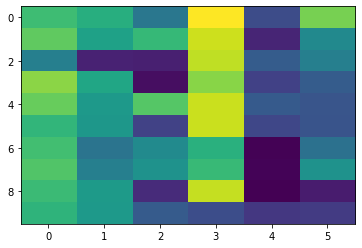

In [41]:
plt.imshow(ks_fine, aspect = 'auto')

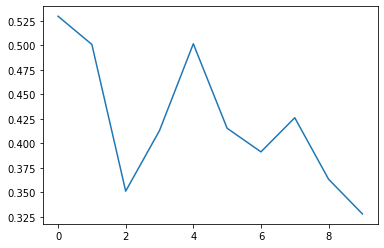

In [42]:
plt.plot(np.mean(ks_fine,axis = 1))

In [ ]:
plt.plot(np.median())

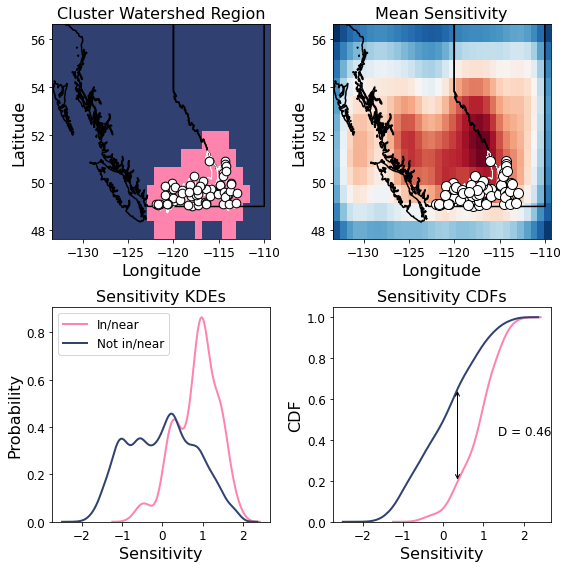

In [39]:
#figure: one cluster heat + one cluster in/out + distributions + cdf

saveIt = 0
saveEPS = 0

cluster = 1
fs= 16

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))

### cluster in/out
inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))

binary_in = np.zeros(np.size(Tmax[0]))
binary_in[unique_in_clusters[cluster]] = 1

im = ax[0,0].imshow(binary_in.reshape(np.shape(Tmax[0])), aspect = 'auto', extent = extentERA, cmap = cmap, norm = norm_binary)    

for ind in inds:
  basin = stationBasins[ind]
  if basin is not None:
      for poly in basin:
          for p in poly:
              x,y = p.exterior.xy
              ax[0,0].plot(x,y,'w', linewidth = 1, zOrder = 3)

ax[0,0].scatter(stationLon[stationInds[inds]], stationLat[stationInds[inds]], s = 75, facecolor = 'w', edgecolor = 'k', zOrder = 4)
plot_prov_ax(prov = prov, ax = ax[0,0])
ax[0,0].tick_params(labelsize = fs-4)
ax[0,0].set_xlabel('Longitude', fontsize = fs)
ax[0,0].set_ylabel('Latitude', fontsize = fs)
ax[0,0].set_title('Cluster Watershed Region', fontsize = fs)
ax[0,0].set_xlim((extentERA[0],extentERA[1]))
ax[0,0].set_ylim((extentERA[2],extentERA[3]))
#plt.colorbar(im, ax = ax[0,0])

### cluster heat
inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
heat_cluster = np.mean(np.asarray(data_norm)[:,inds], axis = 1)
#heat_cluster = np.mean(np.asarray(data)[inds,:], axis = 0)

ax[0,1].imshow(heat_cluster.reshape(np.shape(Tmax[0])), aspect = 'auto', cmap = 'RdBu_r', extent = extentERA)     

for ind in inds:
  basin = stationBasins[ind]
  if basin is not None:
      for poly in basin:
          for p in poly:
              x,y = p.exterior.xy
              ax[0,1].plot(x,y,'w', linewidth = 1, zOrder = 3)

ax[0,1].scatter(stationLon[stationInds[inds]], stationLat[stationInds[inds]], s = 100, facecolor = 'w', edgecolor = 'k', zOrder = 4)
plot_prov_ax(prov = prov, ax = ax[0,1])
ax[0,1].tick_params(labelsize = fs-4)
ax[0,1].set_xlabel('Longitude', fontsize = fs)
ax[0,1].set_ylabel('Latitude', fontsize = fs)
ax[0,1].set_title('Mean Sensitivity', fontsize = fs)
ax[0,1].set_xlim((extentERA[0],extentERA[1]))
ax[0,1].set_ylim((extentERA[2],extentERA[3]))

### distributions 
sns.kdeplot(heat_in_clusters[cluster], ax = ax[1,0], label = 'In/near', color = rgba_binary[1], linewidth = 2)
sns.kdeplot(heat_out_clusters[cluster], ax = ax[1,0], label = 'Not in/near', color = rgba_binary[0], linewidth = 2)
ax[1,0].legend(fontsize = fs-4)
ax[1,0].tick_params(labelsize = fs-4)
ax[1,0].set_xlabel('Sensitivity', fontsize = fs)
ax[1,0].set_ylabel('Probability', fontsize = fs)
ax[1,0].set_title('Sensitivity KDEs', fontsize = fs)

### cdf
cdf_in = sns.kdeplot(heat_in_clusters[cluster], ax = ax[1,1], cumulative = True, color = rgba_binary[1], linewidth = 2, )
cdf_out = sns.kdeplot(heat_out_clusters[cluster], ax = ax[1,1], cumulative = True, color = rgba_binary[0], linewidth = 2)

cdf_xin_data = cdf_in.get_children()[0].get_xdata()
cdf_xout_data = cdf_out.get_children()[1].get_xdata()
cdf_in_data = cdf_in.get_children()[0].get_ydata()
cdf_out_data = cdf_out.get_children()[1].get_ydata()

#interpolate onto same x-axis
from scipy.interpolate import interp1d
x1 = np.max([np.min(cdf_xout_data),np.min(cdf_xin_data)])
x2 = np.min([np.max(cdf_xout_data),np.max(cdf_xin_data)])
cdf_x = np.linspace(x1,x2, num = 100)
f_in = interp1d(cdf_xin_data, cdf_in_data)
cdf_in = f_in(cdf_x)
f_out = interp1d(cdf_xout_data, cdf_out_data)
cdf_out = f_out(cdf_x)

d = np.abs(cdf_in - cdf_out) #not on same x axis, can't just subtract!

p1 = [cdf_x[np.argmax(d)], cdf_in[np.argmax(d)]]
p2 = [cdf_x[np.argmax(d)], cdf_out[np.argmax(d)]]
pmid = np.mean([p1, p2], axis = 0)

plt.annotate(s='', xy=(p2[0],p2[1]), xytext=(p1[0],p1[1]), arrowprops=dict(arrowstyle='<->'))
ax[1,1].text(x = pmid[0]+1, y = pmid[1], s = 'D = ' + str(ks[cluster])[:4], fontsize = fs-4)

ax[1,1].tick_params(labelsize = fs-4)
ax[1,1].set_xlabel('Sensitivity', fontsize = fs)
ax[1,1].set_ylabel('CDF', fontsize = fs)
ax[1,1].set_title('Sensitivity CDFs', fontsize = fs)

fig.tight_layout()

if saveIt:
  plt.savefig('shed_heat_KDE_CDF_ensemble.png', bbox_inches = 'tight', dpi = 200)
if saveEPS:
  plt.savefig('shed_heat_KDE_CDF_ensemble.eps', format = 'eps', bbox_inches='tight')

plt.show()

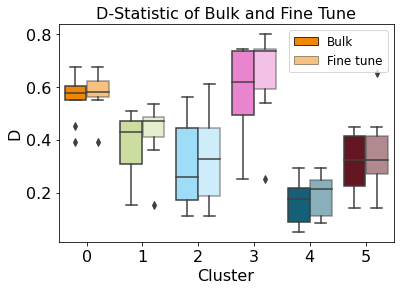

In [40]:
##### D-stat: boxplot of bulk vs fine tune, average of all model runs

saveIt = 0
saveEPS = 0

n_runs = len(runs)

fs = 16

fig = plt.figure(figsize = (6,4))

ax_bp = fig.add_subplot(111)

boxx_bulk = np.tile(np.arange(0,6), (n_runs,))
boxx_fine = np.tile(np.arange(0,6), (n_runs,))

##### NSE

boxy_bulk = np.empty(np.shape(boxx_bulk))
boxy_fine = np.empty(np.shape(boxx_fine))

start = 0
for run in range(n_runs):
  fin = start + 6
  boxy_bulk[start:fin] = ks_bulk[run,:]
  boxy_fine[start:fin] = ks_fine[run,:]
  start = fin
  
boxx = np.hstack((boxx_bulk, boxx_fine))
boxy = np.hstack((boxy_bulk, boxy_fine))

hue = np.hstack((['Bulk' for kk in range(len(boxx_bulk))], ['Fine tune' for kk in range(len(boxx_fine))]))

bp = sns.boxplot(x = boxx, y = boxy, hue = hue, ax = ax_bp)
for kk in range(n_clusters_seasonal):
  bp.artists[2*kk].set_facecolor(rgbs_array[kk])
  bp.artists[2*kk+1].set_facecolor(rgbs_array[kk])
  bp.artists[2*kk+1].set_alpha(0.5)

ax_bp.set_xlabel('Cluster', fontsize = fs)
ax_bp.set_ylabel('D', fontsize = fs)
ax_bp.set_title('D-Statistic of Bulk and Fine Tune', fontsize = fs)
ax_bp.tick_params(labelsize = fs)

leg = ax_bp.legend(loc = 'best', fontsize = fs-4)
leg.legendHandles[0].set_color(rgbs_array[0])
leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_color(rgbs_array[0])
leg.legendHandles[1].set_alpha(0.5)
leg.legendHandles[1].set_edgecolor('k')

# ##### histogram of NSE
# ax_hist = plt.axes([0,0,1,1])
# ip = InsetPosition(ax_bp, [0.6,0.15,0.3,0.3])
# ax_hist.set_axes_locator(ip)

# vmax = np.max(np.abs(dNSE))
# vmin = -vmax
# mapname = 'RdBu'
# cmap = cm.get_cmap(mapname)
# norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
# scalarMap = cm.ScalarMappable(norm = norm, cmap = cmap)

# n, bins, patches = ax_hist.hist(dNSE, edgecolor = 'k')
# colours = scalarMap.to_rgba(bins)
# kk = 0
# for patch in patches:
#   patch.set_facecolor(colours[kk])
#   kk+=1

# ax_hist.set_title('\u0394NSE', fontsize = fs-4)
# ax_hist.set_frame_on = False
# ax_hist.tick_params(labelsize = fs-4)

if saveIt:
  plt.savefig('ks_bulk_fine.png', bbox_inches = 'tight', dpi = 200)
if saveEPS:
  plt.savefig('ks_bulk_fine.eps', format = 'eps', bbox_inches='tight')

# Figures

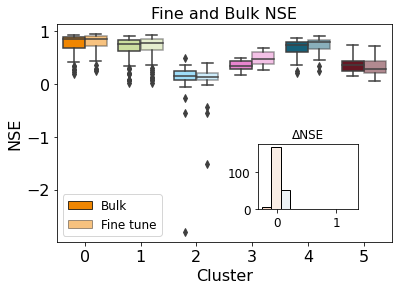

In [84]:
##### NSE: boxplot of bulk vs fine tune, average of all model runs

saveIt = 0
saveEPS = 0

fs = 16 #fontsize

fig = plt.figure(figsize = (6,4))

ax_bp = fig.add_subplot(111) #boxplot axis

#x: cluster labels; y: NSE; hue: bulk/fine
boxx_bulk = seasonal_clustering.labels_ 
boxx_fine = seasonal_clustering.labels_

boxy_bulk = np.mean(NSE_bulk_runs, axis = 0) #average NSE across model runs for each station
boxy_fine = np.mean(NSE_fine_runs, axis = 0)
  
boxx = np.hstack((boxx_bulk, boxx_fine))
boxy = np.hstack((boxy_bulk, boxy_fine))

hue = np.hstack((['Bulk' for kk in range(len(dNSE))], ['Fine tune' for kk in range(len(dNSE))]))

bp = sns.boxplot(x = boxx, y = boxy, hue = hue, ax = ax_bp)
for kk in range(n_clusters_seasonal):
  bp.artists[2*kk].set_facecolor(rgbs_array[kk]) #manually set colour of boxes to match our clusters
  bp.artists[2*kk+1].set_facecolor(rgbs_array[kk])
  bp.artists[2*kk+1].set_alpha(0.5) #fine-tuned boxes set partially transparent

ax_bp.set_xlabel('Cluster', fontsize = fs)
ax_bp.set_ylabel('NSE', fontsize = fs)
ax_bp.set_title('Fine and Bulk NSE', fontsize = fs)
ax_bp.tick_params(labelsize = fs)

leg = ax_bp.legend(loc = 'lower left', fontsize = fs-4)
leg.legendHandles[0].set_color(rgbs_array[0])
leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_color(rgbs_array[0])
leg.legendHandles[1].set_alpha(0.5)
leg.legendHandles[1].set_edgecolor('k')

##### histogram of NSE
ax_hist = plt.axes([0,0,1,1])
ip = InsetPosition(ax_bp, [0.6,0.15,0.3,0.3])
ax_hist.set_axes_locator(ip)

dNSE = boxy_fine - boxy_bulk
vmax = np.max(np.abs(dNSE)) #centre the colourmap around 0 (so blue = better, red = worse)
vmin = -vmax
cmap = cm.get_cmap('RdBu')
norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
scalarMap = cm.ScalarMappable(norm = norm, cmap = cmap)

n, bins, patches = ax_hist.hist(dNSE, edgecolor = 'k')
colours = scalarMap.to_rgba(bins)
for kk, patch in enumerate(patches):
  patch.set_facecolor(colours[kk])

ax_hist.set_title('\u0394NSE', fontsize = fs-4)
ax_hist.set_frame_on = False
ax_hist.tick_params(labelsize = fs-4)

if saveIt:
  plt.savefig('NSE_ensemble_boxplot.png', bbox_inches = 'tight', dpi = 200)
if saveEPS:
  plt.savefig('NSE_ensemble_boxplot.eps', format = 'eps', bbox_inches='tight')

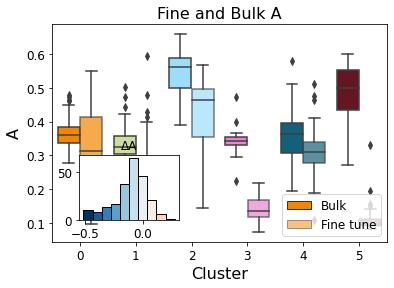

In [86]:
##### A: boxplot of bulk vs fine tune, average of all model runs

saveIt = 0
saveEPS = 0

fs = 16 #fontsize

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,4))

#x: cluster labels; y: A; hue: bulk/fine
boxy_bulk = np.empty(np.shape(boxx_bulk)) 
boxy_fine = np.empty(np.shape(boxx_fine))

boxy_bulk = np.mean(A_bulk_runs, axis = 0) #average A across model runs for each station
boxy_fine = np.mean(A_fine_runs, axis = 0)
  
boxx = np.hstack((boxx_bulk, boxx_fine))
boxy = np.hstack((boxy_bulk, boxy_fine))

hue = np.hstack((['Bulk' for kk in range(len(dA))], ['Fine tune' for kk in range(len(dA))]))
bp = sns.boxplot(x = boxx, y = boxy, hue = hue)
bp.get_legend().remove()
for kk in range(n_clusters_seasonal):
  bp.artists[2*kk].set_facecolor(rgbs_array[kk]) #manually set colour of boxes to match our clusters
  bp.artists[2*kk+1].set_facecolor(rgbs_array[kk])
  bp.artists[2*kk+1].set_alpha(0.7) #fine-tuned boxes set partially transparent

ax.set_xlabel('Cluster', fontsize = fs)
ax.set_ylabel('A', fontsize = fs)
ax.set_title('Fine and Bulk A', fontsize = fs)
ax.tick_params(labelsize = fs-4)
#ax.set_ylim((0,0.6))

leg = ax.legend(loc = 'lower right', fontsize = fs-4)
leg.legendHandles[0].set_color(rgbs_array[0])
leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_color(rgbs_array[0])
leg.legendHandles[1].set_alpha(0.5)
leg.legendHandles[1].set_edgecolor('k')

##### histogram of NSE
ax_hist = plt.axes([0,0,1,1])
ip = InsetPosition(ax, [0.08,0.1,0.3,0.3])
ax_hist.set_axes_locator(ip)
ax_hist.set_title('\u0394A', fontsize = fs-4)
ax_hist.tick_params(labelsize = fs-4)

dA = boxy_fine - boxy_bulk
vmax = np.max(np.abs(dA)) #centre the colourmap around 0 (so blue = better, red = worse)
vmin = -vmax
mapname = 'RdBu_r'
cmap = cm.get_cmap(mapname)
norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)
scalarMap = cm.ScalarMappable(norm = norm, cmap = cmap)

n, bins, patches = ax_hist.hist(dA, edgecolor = 'k')
colours = scalarMap.to_rgba(bins)
for kk, patch in enumerate(patches):
  patch.set_facecolor(colours[kk])

if saveIt:
  plt.savefig('A_ensemble_boxplot.png', bbox_inches = 'tight', dpi = 200)
if saveEPS:
  plt.savefig('A_ensemble_boxplot.eps', format = 'eps', bbox_inches='tight')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

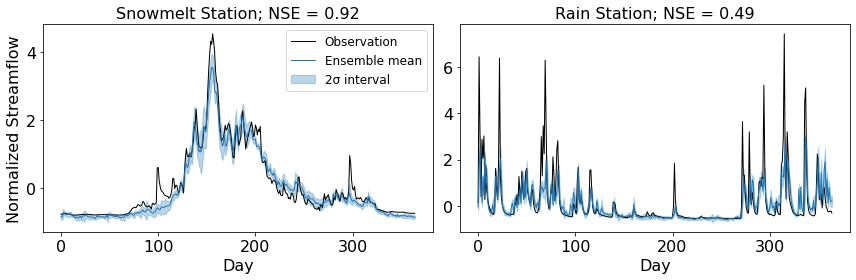

In [ ]:
##### examples of streamflow

saveIt = 0
saveEPS = 0

snowy_cluster = 0
rainy_cluster = 3

snowy_cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_==snowy_cluster))
rainy_cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_==rainy_cluster))

sorted_snowy = np.asarray(NSE_fine_tune)[snowy_cluster_inds].argsort()
sorted_rainy = np.asarray(NSE_fine_tune)[rainy_cluster_inds].argsort()

snowy_ind = snowy_cluster_inds[sorted_snowy[-5]] #take 5th 'best' station
rainy_ind = rainy_cluster_inds[sorted_rainy[-5]]

days = range(365*2, 365*3)

y_test_runs_snowy = np.empty((len(y_test),len(runs)))
y_test_runs_rainy = np.empty((len(y_test),len(runs)))
y_test_runs = np.empty((len(y_test), len(stationInds), len(runs)))

for kk, run in enumerate(runs):

  today_dir_fine = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/' + run + '/fine'
  today_dir_bulk = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/' + run + '/bulk'
  
  fileName = 'y_station_' + str(snowy_ind) + '.csv'
  y_test_runs_snowy[:,kk] = np.squeeze(np.asarray(pd.read_csv(today_dir_fine + '/' + fileName, header = None)))

  fileName = 'y_station_' + str(rainy_ind) + '.csv'
  y_test_runs_rainy[:,kk] = np.squeeze(np.asarray(pd.read_csv(today_dir_fine + '/' + fileName, header = None)))

  # for station in range(len(stationInds)):
  #   fileName = 'y_station_' + str(station) + '.csv'
  #   y_test_runs[:,station,kk] =  np.squeeze(np.asarray(pd.read_csv(today_dir_fine + '/' + fileName, header = None)))

y_err_snowy = 2*np.std(y_test_runs_snowy, axis = 1)
y_mean_snowy = np.mean(y_test_runs_snowy, axis = 1)

y_err_rainy = 2*np.std(y_test_runs_rainy, axis = 1)
y_mean_rainy = np.mean(y_test_runs_rainy, axis = 1)

x_days = np.arange(len(y_mean_snowy))

fb1_snowy = y_mean_snowy - y_err_snowy
fb2_snowy = y_mean_snowy + y_err_snowy

fb1_rainy = y_mean_rainy - y_err_rainy
fb2_rainy = y_mean_rainy + y_err_rainy

rgb = '#1f77b4' #colour for shading that I like (picked from coolors.co)

fs = 16 #fontsize

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

ax[0].plot(range(365), y_test.numpy()[days,snowy_ind], label = 'Observation', color = 'k', linewidth = 1)
ax[0].fill_between(range(365), fb1_snowy[days], fb2_snowy[days], alpha = 0.3, label = '2\u03C3 interval', color = rgb)
ax[0].plot(range(365), y_mean_snowy[days], label = 'Ensemble mean', color = rgb, linewidth = 1)
ax[0].set_ylabel('Normalized Streamflow', fontsize = fs)
ax[0].set_xlabel('Day', fontsize = fs)
ax[0].set_title('Snowmelt Station; NSE = ' + str(np.mean(NSE_fine_runs[:,snowy_ind]))[:4], fontsize = fs)
ax[0].tick_params(labelsize = fs)
ax[0].legend(fontsize = fs-4)

ax[1].plot(range(365), y_test.numpy()[days,rainy_ind], color = 'k', linewidth = 1)
ax[1].fill_between(range(365), fb1_rainy[days], fb2_rainy[days], alpha = 0.3, color = rgb)
ax[1].plot(range(365), y_mean_rainy[days], color = rgb, linewidth = 1)
ax[1].set_xlabel('Day', fontsize = fs)
ax[1].set_title('Rain Station; NSE = ' + str(np.mean(NSE_fine_runs[:,rainy_ind]))[:4], fontsize = fs)
ax[1].tick_params(labelsize = fs)

fig.tight_layout()

if saveIt:
  plt.savefig('streamflow_ensemble_examples.png', bbox_inches = 'tight', dpi = 200)
if saveEPS:
  plt.savefig('streamflow_ensemble_examples.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [76]:
np.median(A_fine), np.median(A_bulk)

(0.3671875, 0.3671875)

In [77]:
dA

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [79]:
np.shape(heat_mean_fine)

(384, 226)

In [29]:
heat_mean_bulk = make_heat(
    model = model_bulk, 
    x_test = x_test, 
    y_test = y_test, 
    style_dict = style_dict, 
    days = days_heat, 
    iters_total = iters_total, 
    iters_one_pass = iters_one_pass, 
    stationInds = range(len(stationInds)),
    verbose = 1
    )

 Day 0/365
 Day 50/365
 Day 100/365
 Day 150/365
 Day 200/365
 Day 250/365
 Day 300/365
 Day 350/365


In [30]:
fileName = 'heat_mean_bulk_' + str(ii) + '.csv'
np.savetxt(output_dir_bulk_heat + '/' + fileName, heat_mean_bulk, delimiter = ',')

In [63]:
seeds = [00, 11, 22, 33, 44, 55, 66, 77, 88, 99] #random seeds to use for reproducability
#seeds = [00]
seeds = [11, 22, 33, 44, 55, 66, 77, 88, 99]
seeds = [55, 66, 77, 88, 99]

sigma = 1.5
style_dict = {'style' : 'gauss',
              'params' : sigma}

days_heat = range(365*5)
iters_total = 200
iters_one_pass = 50
output_dir_heat = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/heat'

In [66]:
heat_mean_fine = np.zeros_like(heat_mean_bulk)
ii = 4
batch_size = 64
#prep fine-tune target output
y_train_predict_fine_all = np.empty_like(y_train)
y_val_predict_fine_all = np.empty_like(y_val)
y_test_predict_fine_all = np.empty_like(y_test)
for cluster in range(n_clusters_seasonal):

  model_name = 'model_fine_' + str(4) + '_cluster_' + str(cluster) + '.h5'
  model_fine = tf.keras.models.load_model(dir_all_models + '/' + model_name)

  print('Training fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal))

  stations_fine = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster)) #stations in this cluster
  N_stations = len(stations_fine) #number of stations in this cluster
  
  #create target datasets (note: x is the same)
  y_train_fine_current = tf.convert_to_tensor(y_train.numpy()[:,stations_fine])
  y_val_fine_current = tf.convert_to_tensor(y_val.numpy()[:,stations_fine])
  y_test_fine_current = tf.convert_to_tensor(y_test.numpy()[:,stations_fine])

  train_dataset_fine = tf.data.Dataset.from_tensor_slices((x_train,y_train_fine_current)).shuffle(Ntrain).batch(batch_size = batch_size)
  val_dataset_fine = tf.data.Dataset.from_tensor_slices((x_val,y_val_fine_current)).shuffle(Nval).batch(batch_size = batch_size)

  #predict train/val/test streamflow
  y_train_predict_fine = model_fine.predict(x_train, batch_size = batch_size, verbose = 0)
  y_val_predict_fine = model_fine.predict(x_val, batch_size = batch_size, verbose = 0)
  y_test_predict_fine = model_fine.predict(x_test, batch_size = batch_size, verbose = 0)

  #reorganize predictions into array that matches the bulk train/val/test structure
  for kk, station_fine in enumerate(stations_fine):
    y_train_predict_fine_all[:,station_fine] = y_train_predict_fine[:,kk]
    y_val_predict_fine_all[:,station_fine] = y_val_predict_fine[:,kk]
    y_test_predict_fine_all[:,station_fine] = y_test_predict_fine[:,kk]

  #generate fine-tuned heat maps
  print(' Making sensitivity heat maps')
  output_dir_fine_heat = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/heat_maps/fine'
  heat_mean_cluster = make_heat(
      model = model_fine, 
      x_test = x_test, 
      y_test = y_test, 
      style_dict = style_dict, 
      days = days_heat, 
      iters_total = iters_total, 
      iters_one_pass = iters_one_pass, 
      stationInds = stations_fine,
      verbose = 1
      )
  for zz,station in enumerate(stations_fine):
    heat_mean_fine[:,station] = heat_mean_cluster[:,zz]

  #save the in-progress heatmaps in case of crash
  fileName = 'heat_mean_fine_' + str(ii) + '_cluster_' + str(cluster) + '_inprogess.csv'
  np.savetxt(output_dir_fine_heat + '/' + fileName, heat_mean_fine, delimiter = ',')

fileName = 'heat_mean_fine_' + str(ii) + '.csv'
np.savetxt(output_dir_fine_heat + '/' + fileName, heat_mean_fine, delimiter = ',')

Training fine model, cluster 1 / 6
 Making sensitivity heat maps
 Day 0/1825
 Day 50/1825
 Day 100/1825
 Day 150/1825
 Day 200/1825
 Day 250/1825
 Day 300/1825
 Day 350/1825
 Day 400/1825
 Day 450/1825
 Day 500/1825
 Day 550/1825
 Day 600/1825
 Day 650/1825
 Day 700/1825
 Day 750/1825
 Day 800/1825
 Day 850/1825
 Day 900/1825
 Day 950/1825
 Day 1000/1825
 Day 1050/1825
 Day 1100/1825
 Day 1150/1825
 Day 1200/1825
 Day 1250/1825
 Day 1300/1825
 Day 1350/1825
 Day 1400/1825
 Day 1450/1825
 Day 1500/1825
 Day 1550/1825
 Day 1600/1825
 Day 1650/1825
 Day 1700/1825
 Day 1750/1825
 Day 1800/1825
Training fine model, cluster 2 / 6
 Making sensitivity heat maps
 Day 0/1825
 Day 50/1825
 Day 100/1825
 Day 150/1825
 Day 200/1825
 Day 250/1825
 Day 300/1825
 Day 350/1825
 Day 400/1825
 Day 450/1825
 Day 500/1825
 Day 550/1825
 Day 600/1825
 Day 650/1825
 Day 700/1825
 Day 750/1825
 Day 800/1825
 Day 850/1825
 Day 900/1825
 Day 950/1825
 Day 1000/1825
 Day 1050/1825
 Day 1100/1825
 Day 1150/1825
 

In [39]:
dir_all_outputs = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/final_model_output'
file_train = 'y_train_fine_predict_' + str(ii) + '.csv'
file_val = 'y_val_fine_predict_' + str(ii) + '.csv'
file_test = 'y_test_fine_predict_' + str(ii) + '.csv'
if not os.path.exists(dir_all_outputs):
  os.mkdir(dir_all_outputs)
np.savetxt(dir_all_outputs + '/' + file_train, y_train_predict_fine_all, delimiter = ',')
np.savetxt(dir_all_outputs + '/' + file_val, y_val_predict_fine_all, delimiter = ',')
np.savetxt(dir_all_outputs + '/' + file_test, y_test_predict_fine_all, delimiter = ',')

In [ ]:
heat_mean = make_heat(
    model = model_bulk, 
    x_test = x_test, 
    y_test = y_test, 
    style_dict = style_dict, 
    days = range(100),#days_heat, 
    iters_total = iters_total, 
    iters_one_pass = iters_one_pass, 
    stationInds = range(len(stationInds)),
    verbose = 1
    )

 Day 0/100
 Day 50/100


In [ ]:
if saveFiles:

  fileName = 'heat_mean_bulk' + str(station) + '.csv'

  if not os.path.exists(output_dir):
    os.mkdir(output_dir)
  np.savetxt(output_dir + '/' + fileName, heat_mean[zz], delimiter = ',')

In [67]:
plt.imshow(np.reshape(heat_mean[:,0], np.shape(Tmax[0,:,:])), aspect = 'auto')

NameError: ignored

In [ ]:
heat_mean[:,0]/2

array([6.73040545e-08, 1.09461823e-07, 1.46582657e-07, 1.55716204e-07,
       1.25490315e-07, 8.03966256e-08, 5.45536352e-08, 5.60032751e-08,
       7.68594395e-08, 1.14929323e-07, 1.63562050e-07, 2.00523756e-07,
       2.21773458e-07, 2.57866730e-07, 3.19515995e-07, 3.78077789e-07,
       4.14945658e-07, 4.24307265e-07, 3.92552924e-07, 3.35645970e-07,
       3.05924762e-07, 3.20366641e-07, 3.38328661e-07, 3.28409165e-07,
       3.14819284e-07, 3.47165788e-07, 4.19602292e-07, 4.54237107e-07,
       4.00241694e-07, 2.95055818e-07, 2.01072963e-07, 1.34898842e-07,
       7.27216147e-08, 1.23263720e-07, 1.77059884e-07, 2.03258922e-07,
       1.77687237e-07, 1.25441630e-07, 9.58298863e-08, 1.05341188e-07,
       1.36254970e-07, 1.76457997e-07, 2.25602075e-07, 2.67483133e-07,
       2.93937083e-07, 3.34123948e-07, 3.98902072e-07, 4.55230467e-07,
       4.88730126e-07, 5.11592506e-07, 5.17684455e-07, 5.03258469e-07,
       4.98342194e-07, 5.14529374e-07, 5.13146855e-07, 4.69814342e-07,
      

In [ ]:
heat_mean[:,0]

array([6.73040545e-06, 1.09461823e-05, 1.46582657e-05, 1.55716204e-05,
       1.25490315e-05, 8.03966256e-06, 5.45536352e-06, 5.60032751e-06,
       7.68594395e-06, 1.14929323e-05, 1.63562050e-05, 2.00523756e-05,
       2.21773458e-05, 2.57866730e-05, 3.19515995e-05, 3.78077789e-05,
       4.14945658e-05, 4.24307265e-05, 3.92552924e-05, 3.35645970e-05,
       3.05924762e-05, 3.20366641e-05, 3.38328661e-05, 3.28409165e-05,
       3.14819284e-05, 3.47165788e-05, 4.19602292e-05, 4.54237107e-05,
       4.00241694e-05, 2.95055818e-05, 2.01072963e-05, 1.34898842e-05,
       7.27216147e-06, 1.23263720e-05, 1.77059884e-05, 2.03258922e-05,
       1.77687237e-05, 1.25441630e-05, 9.58298863e-06, 1.05341188e-05,
       1.36254970e-05, 1.76457997e-05, 2.25602075e-05, 2.67483133e-05,
       2.93937083e-05, 3.34123948e-05, 3.98902072e-05, 4.55230467e-05,
       4.88730126e-05, 5.11592506e-05, 5.17684455e-05, 5.03258469e-05,
       4.98342194e-05, 5.14529374e-05, 5.13146855e-05, 4.69814342e-05,
      

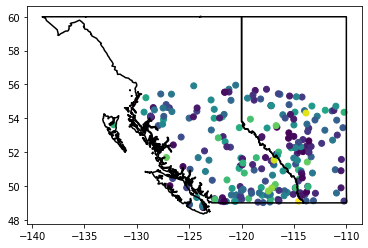

In [ ]:
fig, ax = plt.subplots()
plot_prov_ax(prov = prov, ax = ax)
ax.scatter(stationLon[stationInds], stationLat[stationInds], c = np.abs(yday - yday_mask))

# Additional Figures

In [ ]:
#perturbation + unperturbed temp + perturbed temp

#make perturbation
H = np.shape(x_test)[2] #height of input video, in pixels
W = np.shape(x_test)[3] #width of input video, in pixels

x_int = np.arange(W)
y_int = np.arange(H)

x_mesh, y_mesh = np.meshgrid(x_int, y_int)

sigma = 1.5
pointx = 17
pointy = 3
d2 = (x_mesh - pointx)**2 + (y_mesh - pointy)**2
perturb = np.exp( -d2 / (2*sigma**2))

#visualize
saveIt = 0
saveEPS = 0

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,3))

im = axes[0].imshow(perturb, aspect = 'auto', extent = extentERA)
plot_prov_ax(prov = prov, ax = axes[0])
axes[0].set_title('Perturbation', fontsize = 16)
axes[0].set_xlabel('Longitude', fontsize = 16)
axes[0].set_ylabel('Latitude', fontsize = 16)
plt.colorbar(im, ax = axes[0])

t = np.double(x_test.numpy()[122,0,:,:,0])

im = axes[1].imshow(t, aspect = 'auto', extent = extentERA, cmap = 'RdBu_r')
plot_prov_ax(prov = prov, ax = axes[1])
axes[1].set_title('Maximum Temperature', fontsize = 16)
axes[1].set_xlabel('Longitude', fontsize = 16)
plt.colorbar(im, ax = axes[1])

im = axes[2].imshow(t+perturb, aspect = 'auto', extent = extentERA, cmap = 'RdBu_r')
plot_prov_ax(prov = prov, ax = axes[2])
axes[2].set_title('Perturbed Maximum Temperature', fontsize = 16)
axes[2].set_xlabel('Longitude', fontsize = 16)
plt.colorbar(im, ax = axes[2])

fig.tight_layout()

if saveIt:
  plt.savefig('perturbation.png', dpi = 200, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('perturbation.eps', format = 'eps', bbox_inches='tight')

In [ ]:
#max temp/min temp + precip for the model architecture figure

saveIt = 0
saveEPS = 0

day = 122
cmaps = ['RdBu_r', 'RdBu_r', 'RdBu'] #temperature: red is high; precip: blue is high

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,3))

for kk, ax in enumerate(axes):
  ax.imshow(np.double(x_test.numpy()[0,day,:,:,kk]), aspect = 'auto', extent = extentERA, cmap = cmaps[kk])
  plot_prov_ax(prov = prov, ax = ax)
  ax.set_xlim((extentERA[0], extentERA[1]))
  ax.set_ylim((extentERA[2], extentERA[3]))
  ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)

if saveIt:
  plt.savefig('input_frame.png', dpi = 200, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('input_frame.eps', format = 'eps', bbox_inches='tight')

In [ ]:
#flow field for the model architecture figure

saveIt = 0
saveEPS = 0

day = 440

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,6), frameon = False)
plot_prov_ax(prov=prov, ax = ax)
ax.scatter(stationLon[stationInds], stationLat[stationInds], s = 100, linewidth = 1, edgeColor = 'k', c = np.double(y_test.numpy())[day,:], zOrder = 3, cmap = 'RdBu')
ax.set_xlim((extentERA[0], extentERA[1]))
ax.set_ylim((extentERA[2], extentERA[3]))
ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)

if saveIt:
  plt.savefig('steam_gauge_locations.png', dpi = 200)
if saveEPS:
  plt.savefig('stream_gauge_locations.eps', format = 'eps', bbox_inches='tight')

plt.show()